In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:

import kagglehub
crawford_xception_path = kagglehub.dataset_download('crawford/xception')
mostafaabla_garbage_classification_path = kagglehub.dataset_download('mostafaabla/garbage-classification')

print('Data source import complete.')

Data source import complete.


In [3]:
# CELL 2: Import the necessary libraries
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import keras.applications.xception as xception
import tensorflow.keras as keras
import tensorflow as tf
import re
import zipfile
import sys
import time
from PIL import Image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D, Activation, Lambda
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_recall_fscore_support

print('Setup successful!')

Setup successful!


# 3: Define constants and paths

In [9]:
# Define image size - may increase to improve accuracy
IMAGE_WIDTH = 320
IMAGE_HEIGHT = 320
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

# Path to dataset
base_path = r"C:\Users\ADMIN\.cache\kagglehub\datasets\mostafaabla\garbage-classification\versions\1\garbage_classification\\" 
# IMPORTANT!!! edit the path to dataset depending on where you have it downloaded on your computer. As for my case it was inside C drive

# Dictionary stores 12 types of trash
categories = {0: 'battery', 1: 'biological', 2: 'brown-glass', 3: 'cardboard', 4: 'clothes', 
              5: 'green-glass',6: 'metal', 7: 'paper', 8: 'plastic', 9: 'shoes', 10: 'trash',
              11: 'white-glass'}

print('Defining constants successful!')

Defining constants successful!


# 4: Initial data exploration - examine directories and data structures

In [10]:

print("List of folders in dataset")
for category in categories.values():
    files_count = len(os.listdir(base_path + category))
    print(f"{category}: {files_count} image")

# Display info on original image size
def display_image_stats():
    sample_categories = random.sample(list(categories.values()), 3)
    img_paths = []
    
    for category in sample_categories:
        if os.listdir(base_path + category):
            img_paths.append(base_path + category + '/' + os.listdir(base_path + category)[0])
    
    print("\Information on sample image size:")
    for path in img_paths:
        img = Image.open(path)
        print(f"- Image {os.path.basename(path)} has size of: {img.size}")
        
    # Check few sample to see if the image is error
    print("\nChecking for image error...")
    corrupted_images = []
    
    for category in random.sample(list(categories.values()), 3):
        folder_path = base_path + category
        sample_files = random.sample(os.listdir(folder_path), min(5, len(os.listdir(folder_path))))
        
        for filename in sample_files:
            try:
                img = Image.open(os.path.join(folder_path, filename))
                img.verify()  # Xác minh ảnh không bị hỏng
            except Exception as e:
                corrupted_images.append((os.path.join(folder_path, filename), str(e)))
    
    if corrupted_images:
        print(f"Found {len(corrupted_images)} error image:")
        for img, error in corrupted_images[:5]:
            print(f"- {img}: {error}")
    else:
        print("Does not found image with errors")

# Execute function to check the image
display_image_stats()

List of folders in dataset
battery: 945 image
biological: 985 image
brown-glass: 607 image
cardboard: 891 image
clothes: 5325 image
green-glass: 629 image
metal: 769 image
paper: 1050 image
plastic: 865 image
shoes: 1977 image
trash: 697 image
white-glass: 775 image
\Information on sample image size:
- Image cardboard1.jpg has size of: (512, 384)
- Image paper1.jpg has size of: (275, 183)
- Image clothes1.jpg has size of: (400, 534)

Checking for image error...
Does not found image with errors


<>:15: SyntaxWarning: invalid escape sequence '\I'
<>:15: SyntaxWarning: invalid escape sequence '\I'
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8336\1230115439.py:15: SyntaxWarning: invalid escape sequence '\I'
  print("\Information on sample image size:")


# 5: Display (some) sample images from each class

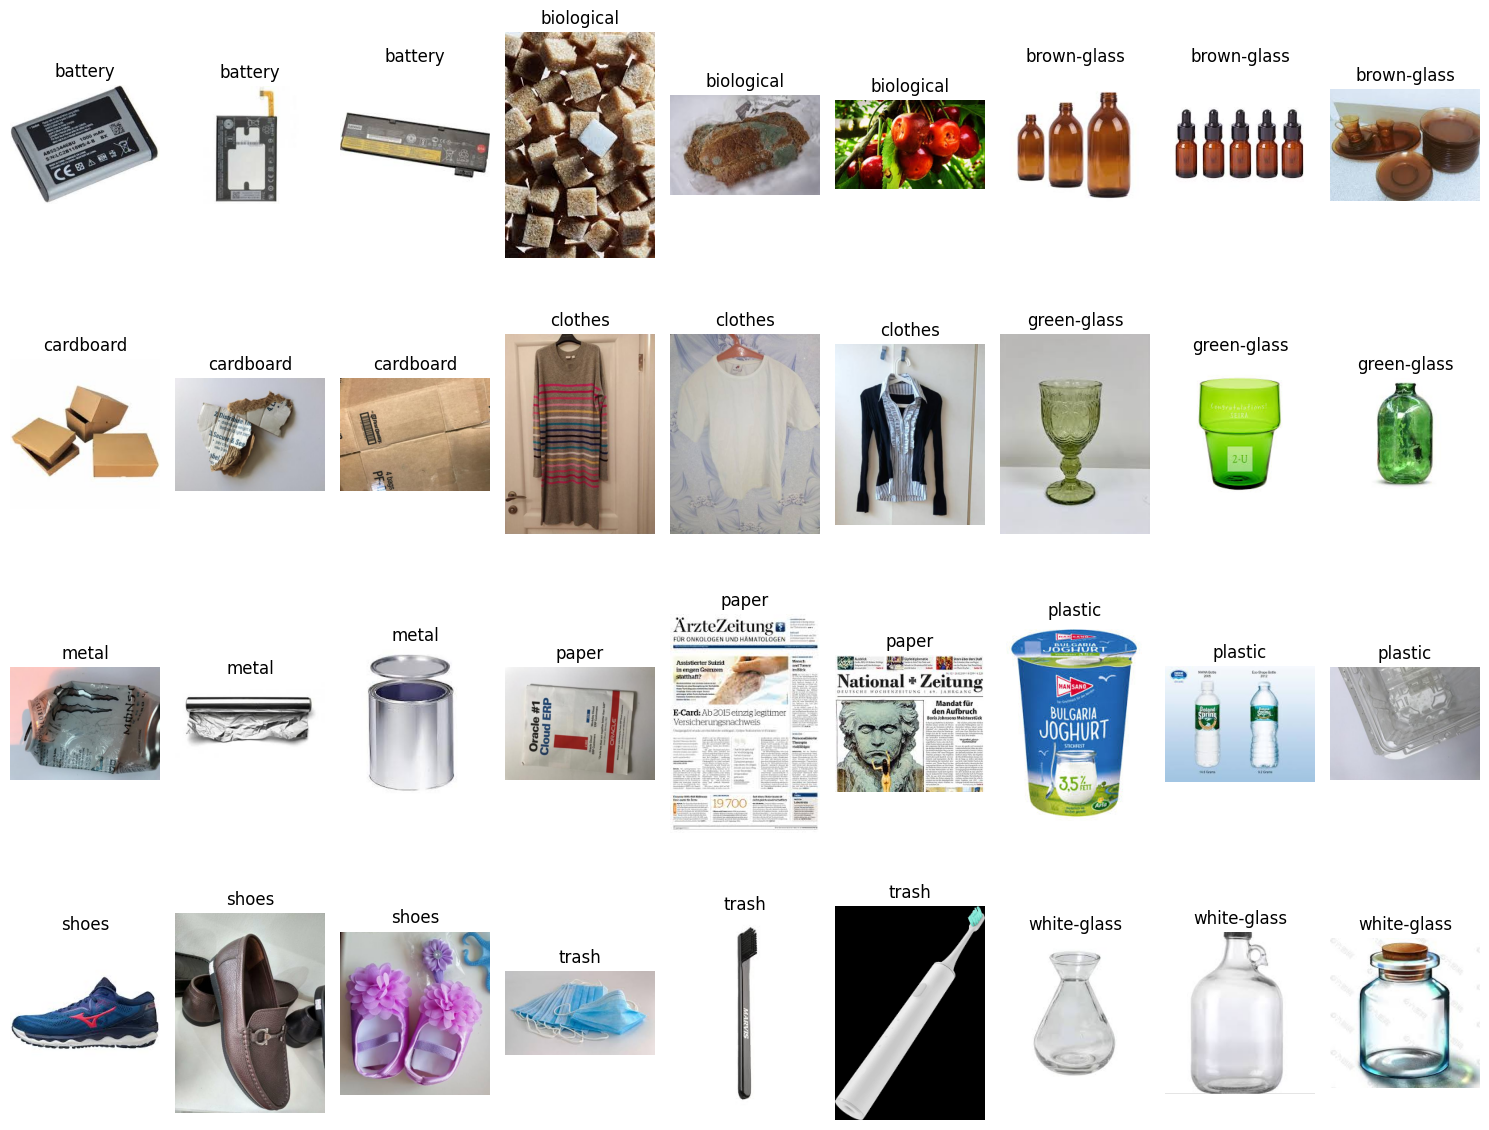

In [11]:
def display_sample_images():
    plt.figure(figsize=(15, 12))
    for i, category in enumerate(categories.values()):
        folder_path = base_path + category
        sample_images = random.sample(os.listdir(folder_path), min(3, len(os.listdir(folder_path))))
        
        for j, img_name in enumerate(sample_images):
            plt.subplot(4, 9, i*3 + j + 1)
            img = Image.open(os.path.join(folder_path, img_name))
            plt.imshow(img)
            plt.title(category)
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Sample image display
display_sample_images()

# 6: Create DataFrame contains info about image and label

In [15]:
# Function to add class name prefix to filename 
# Eg: "/paper104.jpg" thành "paper/paper104.jpg"
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search(r"\d",x).start()] + '/' + x)
    return df

# List containing all file names in the dataset
filenames_list = []
# Corresponding label archive list
categories_list = []

# Go through each layer and collect all the file names and labels.
for category in categories:
    filenames = os.listdir(base_path + categories[category])
    filenames_list = filenames_list + filenames
    categories_list = categories_list + [category] * len(filenames)

# Create DataFrame from list of filenames and labels
df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

# Add class name prefix to file name
df = add_class_name_prefix(df, 'filename')

# Randomize DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print('Number of elements = ', len(df))
print('\nFirst 5 samples:')
print(df.head())

Number of elements =  15515

First 5 samples:
                       filename  category
0        plastic/plastic599.jpg         8
1  biological/biological159.jpg         1
2  green-glass/green-glass1.jpg         5
3       clothes/clothes1214.jpg         4
4           shoes/shoes1026.jpg         9


# 7: Display a random image from the dataset

Display images: cardboard/cardboard557.jpg
Class: cardboard


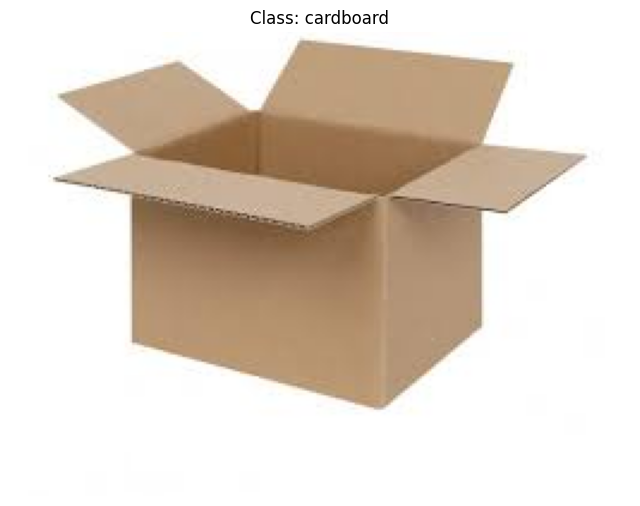

In [13]:
def show_random_image():
    random_row = random.randint(0, len(df)-1)
    sample = df.iloc[random_row]
    randomimage = image.load_img(base_path + sample['filename'])
    
    print(f"Display images: {sample['filename']}")
    print(f"Class: {categories[sample['category']]}")
    
    plt.figure(figsize=(8, 8))
    plt.imshow(randomimage)
    plt.axis('off')
    plt.title(f"Class: {categories[sample['category']]}")
    plt.show()

# Display random image
show_random_image()

# 8: Analyze and visualize class distribution

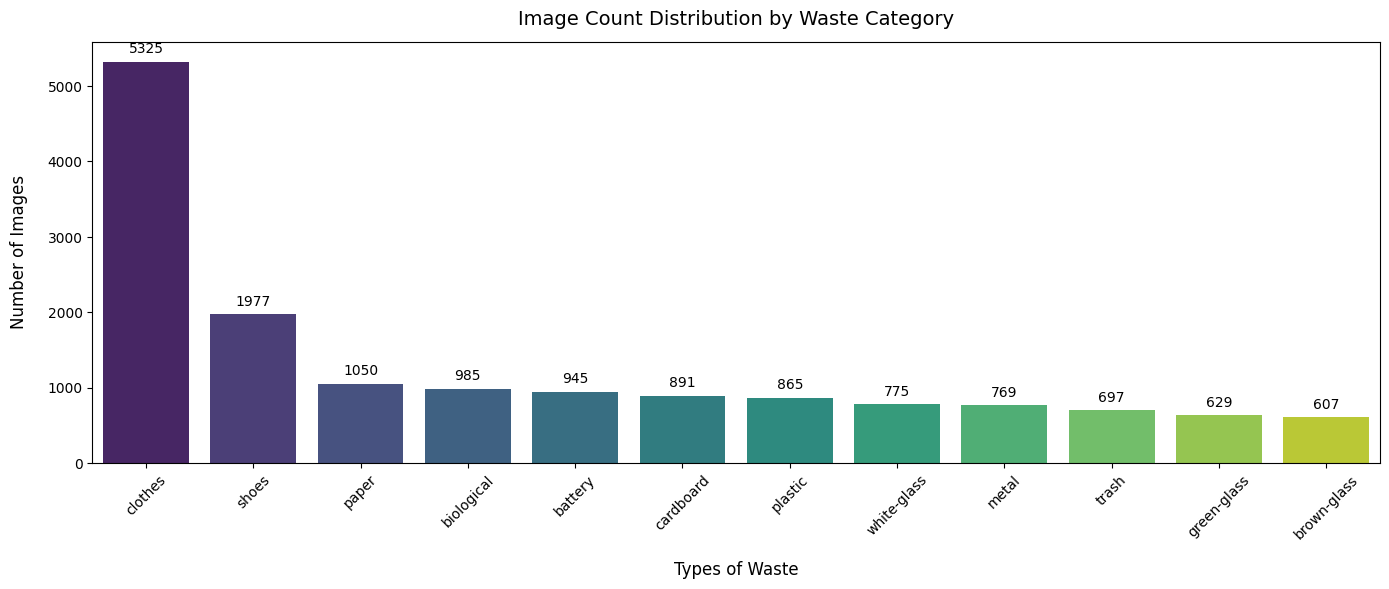

Imbalance ratio (max/min): 8.77
The dataset has significant class imbalance.
Consider using imbalance handling techniques such as class weights or data augmentation.


In [16]:
def visualize_class_distribution():
    df_visualization = df.copy()
    # Convert labels from numbers to names
    df_visualization['category'] = df_visualization['category'].apply(lambda x: categories[x])
    
    # Count the number of images in each class
    class_counts = df_visualization['category'].value_counts()
    
    # Plot the class distribution chart
    plt.figure(figsize=(14, 6))
    ax = sns.barplot(x=class_counts.index, y=class_counts.values, hue=class_counts.index, palette='viridis', legend=False)
    plt.xlabel("Types of Waste", fontsize=12, labelpad=14)
    plt.ylabel("Number of Images", fontsize=12, labelpad=14)
    plt.title("Image Count Distribution by Waste Category", fontsize=14, y=1.02)
    plt.xticks(rotation=45)
    
    # Add value labels on top of each bar
    for p, label in zip(ax.patches, class_counts.values):
        ax.annotate(format(label, '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='center', 
                   xytext=(0, 9), 
                   textcoords='offset points')
    
    plt.tight_layout()
    plt.show()
    
    # Check class imbalance level
    imbalance_ratio = class_counts.max() / class_counts.min()
    print(f"Imbalance ratio (max/min): {imbalance_ratio:.2f}")
    
    if imbalance_ratio > 1.5:
        print("The dataset has significant class imbalance.")
        print("Consider using imbalance handling techniques such as class weights or data augmentation.")
    else:
        print("The dataset is relatively balanced across classes.")

# Execute class distribution analysis
visualize_class_distribution()

# 9: Analyze image size and other attributes

Analyzing image properties...

Image dimension statistics:
Width: Min=159, Max=711, Average=344.72
Height: Min=142, Max=580, Average=349.46
Aspect Ratio: Min=0.50, Max=2.50, Average=1.07
File Size: Min=2.29KB, Max=58.47KB, Average=15.90KB


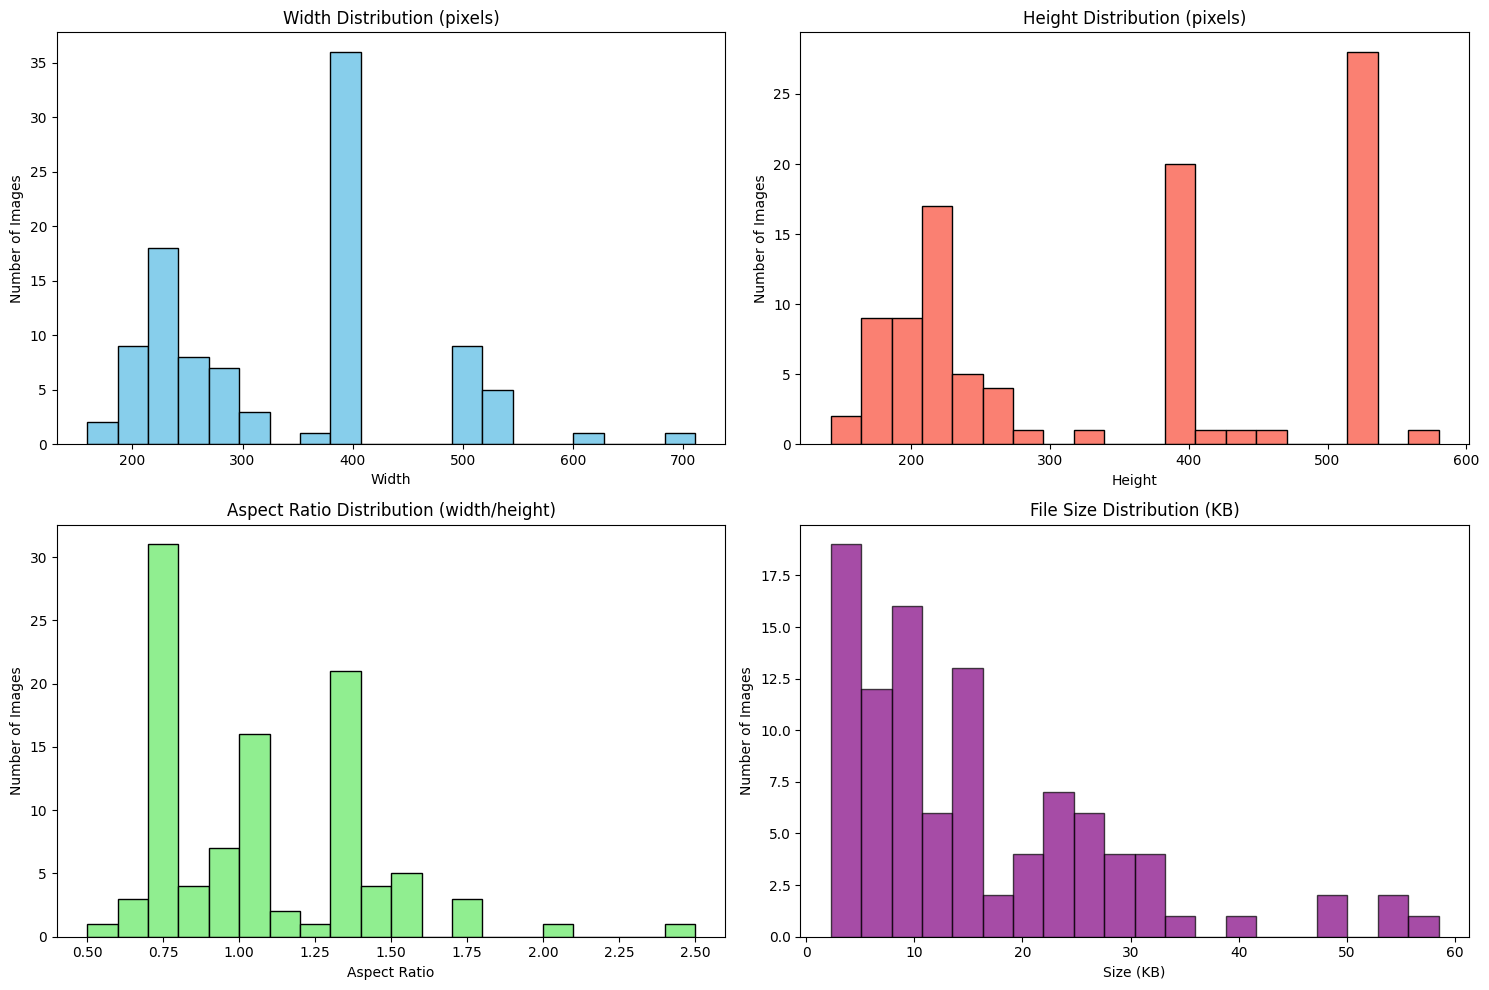

In [17]:
def analyze_image_properties():
    # Select random samples for analysis
    sample_size = 100
    sample_files = random.sample(filenames_list, min(sample_size, len(filenames_list)))
    
    # Initialize lists to store information
    widths = []
    heights = []
    aspect_ratios = []
    file_sizes = []
    
    print("Analyzing image properties...")
    
    for file in sample_files:
        category = file.split('/')[0] if '/' in file else categories[df[df['filename'].str.contains(file)]['category'].iloc[0]]
        img_path = base_path + category + '/' + os.path.basename(file)
        
        try:
            img = Image.open(img_path)
            width, height = img.size
            widths.append(width)
            heights.append(height)
            aspect_ratios.append(width / height)
            file_sizes.append(os.path.getsize(img_path) / 1024)  # Convert to KB
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")
    
    # Display statistics
    print("\nImage dimension statistics:")
    print(f"Width: Min={min(widths)}, Max={max(widths)}, Average={sum(widths)/len(widths):.2f}")
    print(f"Height: Min={min(heights)}, Max={max(heights)}, Average={sum(heights)/len(heights):.2f}")
    print(f"Aspect Ratio: Min={min(aspect_ratios):.2f}, Max={max(aspect_ratios):.2f}, Average={sum(aspect_ratios)/len(aspect_ratios):.2f}")
    print(f"File Size: Min={min(file_sizes):.2f}KB, Max={max(file_sizes):.2f}KB, Average={sum(file_sizes)/len(file_sizes):.2f}KB")
    
    # Visualize dimension distributions
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    plt.hist(widths, bins=20, color='skyblue', edgecolor='black')
    plt.title('Width Distribution (pixels)')
    plt.xlabel('Width')
    plt.ylabel('Number of Images')
    
    plt.subplot(2, 2, 2)
    plt.hist(heights, bins=20, color='salmon', edgecolor='black')
    plt.title('Height Distribution (pixels)')
    plt.xlabel('Height')
    plt.ylabel('Number of Images')
    
    plt.subplot(2, 2, 3)
    plt.hist(aspect_ratios, bins=20, color='lightgreen', edgecolor='black')
    plt.title('Aspect Ratio Distribution (width/height)')
    plt.xlabel('Aspect Ratio')
    plt.ylabel('Number of Images')
    
    plt.subplot(2, 2, 4)
    plt.hist(file_sizes, bins=20, color='purple', alpha=0.7, edgecolor='black')
    plt.title('File Size Distribution (KB)')
    plt.xlabel('Size (KB)')
    plt.ylabel('Number of Images')
    
    plt.tight_layout()
    plt.show()

# Execute image property analysis
analyze_image_properties()

# 10: Split the data into training, validation, and test sets

In [18]:
# Convert labels from numbers to names before splitting the data
df["category_name"] = df["category"].apply(lambda x: categories[x])

# Split the data: 70% training, 15% validation, 15% testing
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['category'])
validate_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['category'])

# Reset indices
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Save dataset sizes for later use
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
total_test = test_df.shape[0]

print('Training set size =', total_train)
print('Validation set size =', total_validate)
print('Test set size =', total_test)

# Check class distribution in each dataset
print("\nClass distribution in training set:")
print(train_df['category_name'].value_counts())

print("\nClass distribution in validation set:")
print(validate_df['category_name'].value_counts())

print("\nClass distribution in test set:")
print(test_df['category_name'].value_counts())

Training set size = 10860
Validation set size = 2327
Test set size = 2328

Class distribution in training set:
category_name
clothes        3727
shoes          1384
paper           735
biological      689
battery         661
cardboard       624
plastic         606
white-glass     543
metal           538
trash           488
green-glass     440
brown-glass     425
Name: count, dtype: int64

Class distribution in validation set:
category_name
clothes        799
shoes          296
paper          157
biological     148
battery        142
cardboard      133
plastic        129
white-glass    116
metal          116
trash          105
green-glass     95
brown-glass     91
Name: count, dtype: int64

Class distribution in test set:
category_name
clothes        799
shoes          297
paper          158
biological     148
battery        142
cardboard      134
plastic        130
white-glass    116
metal          115
trash          104
green-glass     94
brown-glass     91
Name: count, dtype: int64


# 11: Calculate class weights to handle data imbalance

In [19]:
def calculate_class_weights():
    # Calculate the number of samples in each class
    class_counts = train_df['category'].value_counts().sort_index()
    
    # Compute class weights
    n_samples = len(train_df)
    n_classes = len(categories)
    
    class_weights = {}
    for i, count in enumerate(class_counts):
        class_weights[i] = n_samples / (n_classes * count)
    
    # Normalize class weights
    max_weight = max(class_weights.values())
    for i in class_weights:
        class_weights[i] = class_weights[i] / max_weight
    
    print("Calculated class weights:")
    for i, weight in class_weights.items():
        print(f"{categories[i]}: {weight:.4f}")
    
    return class_weights

# Compute class weights
class_weights = calculate_class_weights()

Calculated class weights:
battery: 0.6430
biological: 0.6168
brown-glass: 1.0000
cardboard: 0.6811
clothes: 0.1140
green-glass: 0.9659
metal: 0.7900
paper: 0.5782
plastic: 0.7013
shoes: 0.3071
trash: 0.8709
white-glass: 0.7827


# 12: Prepare data generators with data augmentation

In [20]:
def create_data_generators():
    batch_size = 32
    
    # Generator for the training set with data augmentation
    train_datagen = image.ImageDataGenerator(
        rotation_range=20,             # Randomly rotate images within 20 degrees
        width_shift_range=0.1,         # Horizontally shift images by 10%
        height_shift_range=0.1,        # Vertically shift images by 10%
        shear_range=0.1,               # Apply shear transformations
        zoom_range=0.2,                # Zoom in/out by 20%
        horizontal_flip=True,          # Flip images horizontally
        fill_mode='nearest'            # Fill in missing pixels
    )
    
    # Generator for validation and test sets (no augmentation)
    valid_test_datagen = image.ImageDataGenerator()
    
    # Create generator for the training set
    train_generator = train_datagen.flow_from_dataframe(
        train_df,
        base_path,
        x_col='filename',
        y_col='category_name',
        target_size=IMAGE_SIZE,
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True
    )
    
    # Create generator for the validation set
    validation_generator = valid_test_datagen.flow_from_dataframe(
        validate_df,
        base_path,
        x_col='filename',
        y_col='category_name',
        target_size=IMAGE_SIZE,
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=False
    )
    
    # Create generator for the test set
    test_generator = valid_test_datagen.flow_from_dataframe(
        test_df,
        base_path,
        x_col='filename',
        y_col='category_name',
        target_size=IMAGE_SIZE,
        class_mode='categorical',
        batch_size=1,  # Batch size 1 to make evaluating individual samples easier
        shuffle=False
    )
    
    # Save the mapping dictionary between class names and indices
    class_indices = train_generator.class_indices
    class_indices_inv = {v: k for k, v in class_indices.items()}
    
    print("Class indices:")
    for cls_name, idx in class_indices.items():
        print(f"{cls_name}: {idx}")
    
    return train_generator, validation_generator, test_generator, class_indices, class_indices_inv, batch_size

# Create generators
train_generator, validation_generator, test_generator, class_indices, class_indices_inv, batch_size = create_data_generators()

Found 10860 validated image filenames belonging to 12 classes.
Found 2327 validated image filenames belonging to 12 classes.
Found 2328 validated image filenames belonging to 12 classes.
Class indices:
battery: 0
biological: 1
brown-glass: 2
cardboard: 3
clothes: 4
green-glass: 5
metal: 6
paper: 7
plastic: 8
shoes: 9
trash: 10
white-glass: 11


# 13: Show some images with data augmentation applied

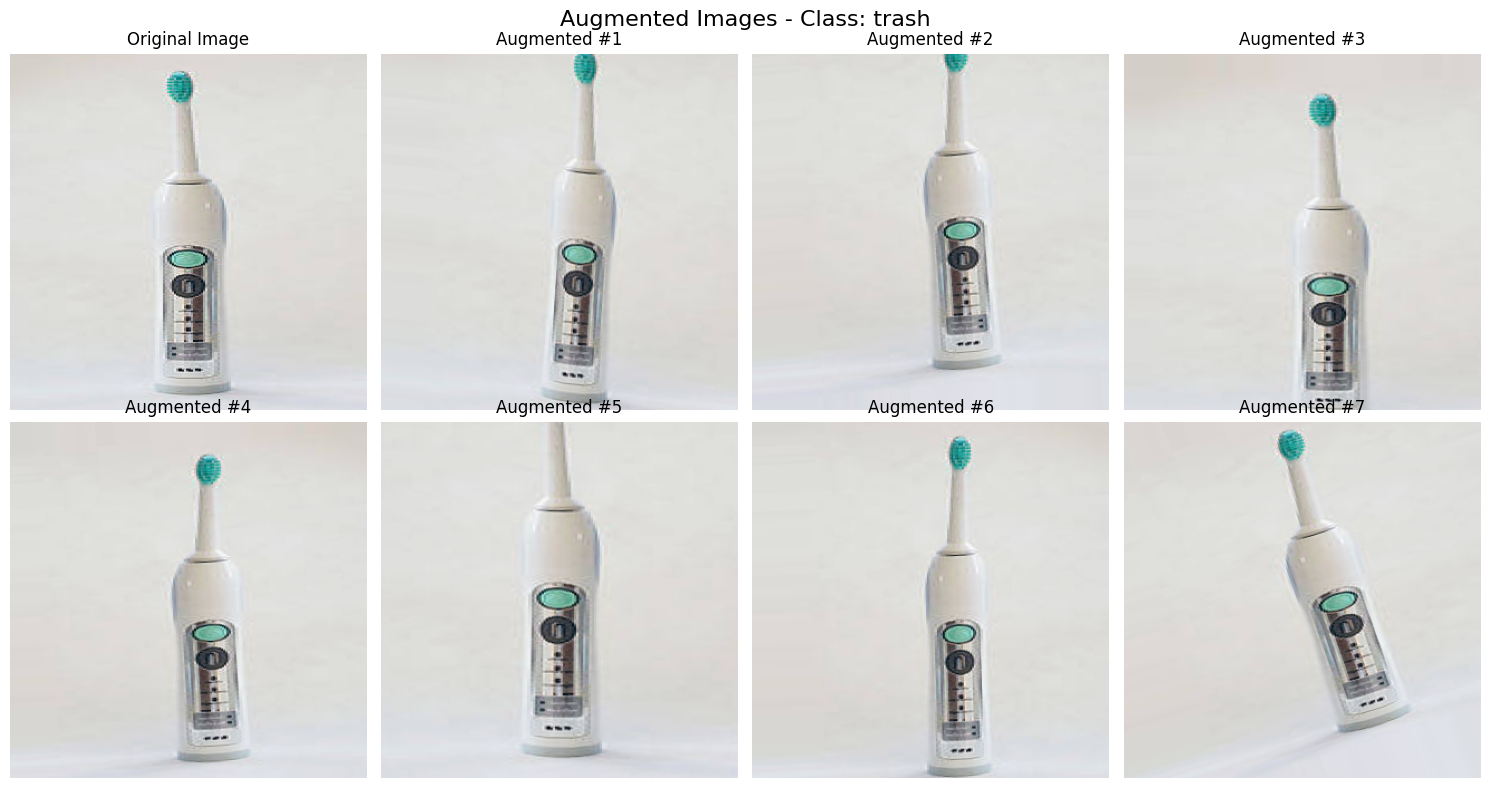

In [21]:
def show_augmented_images():
    # Select a random image sample from the training set
    sample_df = train_df.sample(1)
    sample_class = sample_df['category_name'].values[0]
    sample_path = base_path + sample_df['filename'].values[0]
    
    # Load the image and prepare it for augmentation
    sample_img = image.load_img(sample_path, target_size=IMAGE_SIZE)
    x = image.img_to_array(sample_img)
    x = x.reshape((1,) + x.shape)
    
    # Create a temporary generator with the same augmentation settings as train_datagen
    aug_datagen = image.ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    # Plot the original and augmented images
    plt.figure(figsize=(15, 8))
    
    # Show the original image
    plt.subplot(2, 4, 1)
    plt.imshow(sample_img)
    plt.title('Original Image')
    plt.axis('off')
    
    # Show the augmented images
    i = 1
    for batch in aug_datagen.flow(x, batch_size=1):
        plt.subplot(2, 4, i+1)
        plt.imshow(image.array_to_img(batch[0]))
        plt.title(f'Augmented #{i}')
        plt.axis('off')
        i += 1
        if i > 7:  # Show up to 7 augmented images
            break
    
    plt.suptitle(f'Augmented Images - Class: {sample_class}', fontsize=16)
    plt.tight_layout()
    plt.show()

# Show augmented images
show_augmented_images()

# 14: Modeling with transfer learning using Xception

In [25]:
def create_xception_model():
    # Load pretrained Xception model without the final classification layer
    xception_layer = xception.Xception(
        include_top=False, 
        input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS),
        weights=r"C:\Users\ADMIN\.cache\kagglehub\datasets\crawford\xception\versions\2\xception_weights_tf_dim_ordering_tf_kernels_notop.h5"
        # Also remember to link path to the model downloaded
    )
    
    # Freeze layers in Xception (do not retrain)
    xception_layer.trainable = False
    
    # Create sequential model
    model = Sequential([
        # Input layer
        keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)),
        
        # Preprocessing function for Xception
        Lambda(lambda img: xception.preprocess_input(img)),
        
        # Add Xception base model
        xception_layer,
        
        # Add new classification layers
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.3),  # Add dropout to reduce overfitting
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(len(categories), activation='softmax')
    ])
    
    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    
    return model

# Create model
model = create_xception_model()

# Show model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 320, 320, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 10, 10, 2048)   │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12)             │         3,084 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,044,980 (84.09 MB)

 Trainable params: 1,183,500 (4.51 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

# 15: Prepare callbacks to monitor and adjust the training process

In [26]:
def create_callbacks():
    # Early stopping to stop training when performance doesn't improve
    early_stop = EarlyStopping(
        monitor='val_categorical_accuracy',
        patience=5,
        verbose=1,
        mode='max',
        min_delta=0.001,
        restore_best_weights=True
    )
    
    # Reduce learning rate when performance plateaus
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        verbose=1,
        min_delta=0.001,
        min_lr=1e-6
    )
    
    # Save the best model - use .keras format instead of .h5
    checkpoint = ModelCheckpoint(
        'best_garbage_classification_model.keras',
        monitor='val_categorical_accuracy',
        mode='max',
        verbose=1,
        save_best_only=True
    )
    
    return [early_stop, reduce_lr, checkpoint]

# Create callbacks
callbacks = create_callbacks()

# 16: Model training

In [1]:
def train_model(epochs=20):
    print("Starting model training...")

    # Record start time
    start_time = time.time()

    # Train the model
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
        callbacks=callbacks,
        class_weight=class_weights,  # Use class weights to handle imbalance
        verbose=1
    )

    # Calculate training time
    training_time = time.time() - start_time
    hours = int(training_time // 3600)
    minutes = int((training_time % 3600) // 60)
    seconds = int(training_time % 60)

    print(f"Training completed in {hours}h {minutes}m {seconds}s")

    return history

# Train the model
history = train_model(epochs=20)

# Save model weights - use .keras format instead of .h5
model.save("/kaggle/working/garbage_classification_model.keras")
print("Model saved successfully!")

Starting model training...


NameError: name 'time' is not defined

There is a difference of about 2.2% between:

Training accuracy: 98.03%
Validation accuracy: 95.83%

This difference suggests a slight degree of overfitting — the model performs better on the seen data (training set) compared to the unseen data (validation set). However, the gap is not too large, so it is still acceptable.

# 17: Visualize the training process

In [ ]:
def visualize_training_history(history):
    # Create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot loss graph
    ax1.plot(history.history['loss'], color='blue', linestyle='-', linewidth=2, label="Training loss")
    ax1.plot(history.history['val_loss'], color='red', linestyle='-', linewidth=2, label="Validation loss")
    ax1.set_title('Model Loss', fontsize=14)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.legend(fontsize=10)
    
    # Plot accuracy graph
    ax2.plot(history.history['categorical_accuracy'], color='blue', linestyle='-', linewidth=2, label="Training accuracy")
    ax2.plot(history.history['val_categorical_accuracy'], color='red', linestyle='-', linewidth=2, label="Validation accuracy")
    ax2.set_title('Model Accuracy', fontsize=14)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.6)
    ax2.legend(fontsize=10)
    
    # Find epoch with highest validation accuracy
    best_epoch = np.argmax(history.history['val_categorical_accuracy'])
    best_acc = history.history['val_categorical_accuracy'][best_epoch]
    
    # Mark best epoch
    ax2.annotate(f'Best: {best_acc:.4f}', 
                xy=(best_epoch, best_acc),
                xytext=(best_epoch, best_acc-0.1),
                arrowprops=dict(facecolor='black', shrink=0.05),
                fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Show additional info
    print(f"Starting training accuracy: {history.history['categorical_accuracy'][0]:.4f}")
    print(f"Final training accuracy: {history.history['categorical_accuracy'][-1]:.4f}")
    print(f"Starting validation accuracy: {history.history['val_categorical_accuracy'][0]:.4f}")
    print(f"Final validation accuracy: {history.history['val_categorical_accuracy'][-1]:.4f}")
    print(f"Best validation accuracy: {best_acc:.4f} at epoch {best_epoch+1}")

# Show training process plots
visualize_training_history(history)

# 18: Performance evaluation on test set

In [ ]:
def evaluate_model():
    print("Evaluating model on test set...")
    
    # Evaluate overall performance
    test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
    print(f'Accuracy on test set: {test_accuracy*100:.2f}%')
    
    # Get predictions
    print("Generating predictions for test set...")
    test_generator.reset()  # Reset generator to start
    
    # Predict on test set
    y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Convert true labels from generators
    y_true = test_generator.classes
    
    # Create classification report
    print("\nDetailed classification report:")
    # Use class names from class_indices_inv
    class_names = [class_indices_inv[i] for i in range(len(class_indices_inv))]
    print(classification_report(y_true, y_pred_classes, target_names=class_names))
    
    return y_true, y_pred_classes, class_names

# Perform evaluation
y_true, y_pred_classes, class_names = evaluate_model()

# 19: Plot confusion matrix

In [ ]:
def display_confusion_matrix(y_true, y_pred_classes, class_names):
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    
    # Create normalized confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    class_names = [class_indices_inv[i] for i in range(len(class_indices_inv))]
    
    # Set figure size based on number of classes
    plt.figure(figsize=(16, 14))
    
    # Display confusion matrix - without showing numbers
    plt.figure(figsize=(16, 14))
    
    ax = plt.subplot()
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                annot_kws={"size": 12}, # Tăng kích thước chữ số
                cbar_kws={"shrink": 0.8})
    
    plt.title('Normalized Confusion Matrix', fontsize=18)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.xticks(fontsize=12, rotation=45, ha='right')
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()
    print("5 most common misclassification:")
    misclassifications = []
    
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and cm[i, j] > 0:
                misclassifications.append((
                    class_names[i],   # Lớp thực tế
                    class_names[j],   # Lớp dự đoán
                    cm[i, j],         # Số lượng
                    cm[i, j]/np.sum(cm[i, :])*100  # Phần trăm
                ))
    
    misclassifications.sort(key=lambda x: x[2], reverse=True)
    
    
    for true_cls, pred_cls, count, percentage in misclassifications[:5]:
        print(f"- True: {true_cls}, Prediction: {pred_cls}, Count: {int(count)} ({percentage:.2f}%)")

# Display confusion matrix
display_confusion_matrix(y_true, y_pred_classes, class_names)

In [ ]:
def analyze_misclassifications():
    # Find indices of misclassified samples
    misclassified_indices = np.where(y_pred_classes != y_true)[0]
    
    if len(misclassified_indices) == 0:
        print("No misclassified samples found in the test set!")
        return
    
    print(f"Found {len(misclassified_indices)} misclassified samples.")
    
    # Display some misclassified samples
    num_examples = min(10, len(misclassified_indices))
    fig = plt.figure(figsize=(15, num_examples * 2))
    
    for i, idx in enumerate(misclassified_indices[:num_examples]):
        # Get image path
        img_path = base_path + test_df.iloc[idx]['filename']
        
        # Load and display image
        img = image.load_img(img_path, target_size=IMAGE_SIZE)
        
        # Process image for prediction
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = xception.preprocess_input(x)
        
        # Detailed prediction
        preds = model.predict(x)
        pred_prob = preds[0][y_pred_classes[idx]]  # Probability of predicted class
        
        # True and predicted class names
        true_class = class_indices_inv[y_true[idx]]
        pred_class = class_indices_inv[y_pred_classes[idx]]
        
        # Show image and info
        plt.subplot(num_examples, 2, i*2 + 1)
        plt.imshow(img)
        plt.title(f"True: {true_class}\nPredicted: {pred_class} ({pred_prob:.2f})")
        plt.axis('off')
        
        # Show prediction probability distribution
        plt.subplot(num_examples, 2, i*2 + 2)
        
        # Get top 5 classes with highest probability
        top_indices = np.argsort(preds[0])[-5:][::-1]
        top_classes = [class_indices_inv[idx] for idx in top_indices]
        top_probs = [preds[0][idx] for idx in top_indices]
        
        plt.barh(top_classes, top_probs, color='skyblue')
        plt.xlabel('Probability')
        plt.title('Top 5 classes with highest probability')
        plt.xlim(0, 1)
        plt.grid(axis='x', linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    plt.show()
    
    # Error analysis by class
    print("\nError analysis by class:")
    for class_idx in range(len(class_names)):
        # Get samples belonging to this class
        class_samples = np.where(y_true == class_idx)[0]
        
        if len(class_samples) == 0:
            continue
        
        # Count misclassified samples
        class_errors = np.where(y_pred_classes[class_samples] != class_idx)[0]
        error_rate = len(class_errors) / len(class_samples) * 100
        
        print(f"{class_names[class_idx]}: {error_rate:.2f}% error ({len(class_errors)}/{len(class_samples)})")

# Analyze misclassified samples
analyze_misclassifications()

# 21: Fine-tuning the model to improve performance

In [ ]:
def fine_tune_model():
    global model
    
    print("Starting fine-tuning the model...")
    
    print("Checking model structure before fine-tuning:")
    for i, layer in enumerate(model.layers):
        print(f"Layer {i}: {layer.name}, Trainable: {layer.trainable}")
    
    xception_layer = None
    for layer in model.layers:
        if isinstance(layer, keras.layers.Lambda):
            continue
        if not isinstance(layer, keras.layers.GlobalAveragePooling2D):
            xception_layer = layer
            break
    
    if xception_layer is None:
        print("Cannot find Xception layer, trying alternative method...")
        new_model = create_xception_model()
        
        xception_found = False
        for layer in new_model.layers:
            if hasattr(layer, 'layers') and len(getattr(layer, 'layers', [])) > 50:
                xception_found = True
                break
        
        if not xception_found:
            print("Cannot find Xception layer in new model. Skipping fine-tuning.")
            return None
        
        new_model.set_weights(model.get_weights())
        model = new_model
    
    print("\nCreating new model with last layers unfrozen...")
    
    base_model = xception.Xception(
        include_top=False,
        input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS),
        weights='../input/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5'
    )
    
    for layer in base_model.layers:
        layer.trainable = False
    
    for layer in base_model.layers[-20:]:
        layer.trainable = True
    
    trainable_count = sum(1 for layer in base_model.layers if layer.trainable)
    non_trainable_count = sum(1 for layer in base_model.layers if not layer.trainable)
    
    print(f"Trainable layers in Xception: {trainable_count}")
    print(f"Non-trainable layers in Xception: {non_trainable_count}")
    
    inputs = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))
    x = Lambda(lambda img: xception.preprocess_input(img))(inputs)
    
    x = base_model(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(len(categories), activation='softmax')(x)
    
    new_model = Model(inputs, outputs)
    
    new_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-5),
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    
    fine_tune_callbacks = [
        EarlyStopping(
            monitor='val_categorical_accuracy',
            patience=5,
            verbose=1,
            mode='max',
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=2,
            verbose=1,
            min_lr=1e-7
        ),
        ModelCheckpoint(
            'fine_tuned_model.keras',
            monitor='val_categorical_accuracy',
            mode='max',
            verbose=1,
            save_best_only=True
        )
    ]
    
    print("\nTraining model with fine-tuning:")
    fine_tune_history = new_model.fit(
        train_generator,
        epochs=10,
        validation_data=validation_generator,
        callbacks=fine_tune_callbacks,
        class_weight=class_weights,
        verbose=1
    )
    
    new_model.save("/kaggle/working/fine_tuned_garbage_model.keras")
    print("Fine-tuned model saved successfully!")
    
    model = new_model
    
    return fine_tune_history

fine_tune_history = fine_tune_model()

if fine_tune_history is not None:
    visualize_training_history(fine_tune_history)
else:
    print("Could not perform fine-tuning. Continuing with the current model.")

This result shows the structure of your current model before fine-tuning:

Layer 0: lambda, Trainable: True

This is the first Lambda layer, responsible for preprocessing the input data.
This layer applies the preprocessing function xception.preprocess_input to prepare the images for the Xception model.
Although marked as trainable (Trainable: True), it actually has no parameters to train.

Layer 1: xception, Trainable: False

This is the Xception model used as the backbone for transfer learning.
This layer is set as non-trainable (Trainable: False), meaning during initial training you froze the Xception parameters.
By freezing Xception, you use the knowledge it learned from a large dataset (like ImageNet) without changing its parameters.

Layer 2: global_average_pooling2d, Trainable: True

This is the GlobalAveragePooling2D layer, which reduces the output tensor size from Xception.
This layer has no parameters to train but is still marked as Trainable: True.

Layer 3: dense, Trainable: True

This is the first Dense layer with 512 neurons, using ReLU activation.
It is trainable and contains many parameters (weights and biases).

Layer 4: dropout, Trainable: True

This is a Dropout layer with a rate of 0.3, helping to reduce overfitting.
It has no trainable parameters.

Layer 5: dense_1, Trainable: True

This is the second Dense layer with 256 neurons, also with ReLU activation.
It is trainable.

Layer 6: dropout_1, Trainable: True

Another Dropout layer with a rate of 0.2.
No trainable parameters.

Layer 7: dense_2, Trainable: True

This is the final Dense layer with the number of neurons equal to the number of classes (12 classes) and softmax activation.
It performs the final classification and is trainable.

Meaning for fine-tuning:

Currently, you have a model with the Xception backbone frozen (Trainable: False) and the custom classification layers trained (Trainable: True).
In fine-tuning, the goal is to unlock some of the last layers of Xception to allow them to adapt to your specific data.
However, you cannot directly access the inner layers of Xception from this Sequential model (which caused the original error).
Therefore, the approach in cell 21 is to create a new model with a similar structure but unlock the last layers of Xception.

Cell 21 was adjusted to handle this by:

    Creating a new Xception model
    Freezing most layers except the last 20 layers
    Building a new model with a similar structure
    Performing fine-tuning with a lower learning rate

This process allows the model to fine-tune higher-level features in Xception to better fit your garbage classification data, while keeping the low-level features learned from ImageNet intact.

Comments and Explanation

Training Accuracy:

The Transfer Learning model has higher accuracy (98.03% vs. 93.71%).
This may be because the Fine-tuning model is more complex (more parameters are trained), so it requires more epochs to reach the highest accuracy.

Validation Accuracy:

Both models achieve high accuracy on the validation set (>94.9%).
The Transfer Learning model has slightly higher accuracy (95.83% vs. 94.97%).
This difference is not significant and could be due to random noise.

Generalization Ability:

Although the Transfer Learning model has higher training accuracy, the gap between training and validation accuracy is quite large (98.03% - 95.83% = 2.2%).
This gap is smaller in the Fine-tuning model (93.71% - 94.97% = -1.26%), meaning the model actually performs better on unseen data.
This suggests the Fine-tuning model generalizes better.

Overfitting Issue:

The Transfer Learning model shows mild overfitting (training accuracy significantly higher than validation accuracy).
The Fine-tuning model shows no signs of overfitting (validation accuracy is even higher than training accuracy).

Which Model is Better?

The Fine-tuning model (cell 21) can be considered better in terms of generalization for the following reasons:

    Better generalization: The Fine-tuning model has a smaller gap between training and validation accuracy, even performing better on unseen data.

    Less overfitting: The Fine-tuning model shows no overfitting, while the Transfer Learning model has slight overfitting.

    Potential for improvement: The Fine-tuning model could achieve better performance with more training epochs, as its training curve is still improving.

    More specific features: By unlocking the last layers of Xception, the Fine-tuning model can learn features more specific to garbage classification rather than relying solely on general features learned from ImageNet.

However, if the goal is the highest accuracy on the validation set without much concern for overfitting, the original Transfer Learning model remains a good choice with a validation accuracy of 95.83%.

Conclusion: For practical deployment, I recommend using the Fine-tuning model (cell 21) because of its better generalization ability and potential to perform better on real unseen data.

In [ ]:
# CELL 21B: Continue fine-tuning the model with additional epochs
def continue_fine_tuning(additional_epochs=10):
    print("Continuing fine-tuning the model with additional epochs...")
    
    continue_callbacks = [
        EarlyStopping(
            monitor='val_categorical_accuracy',
            patience=5,
            verbose=1,
            mode='max',
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=2,
            verbose=1,
            min_lr=1e-7
        ),
        ModelCheckpoint(
            'continued_fine_tuned_model.keras',
            monitor='val_categorical_accuracy',
            mode='max',
            verbose=1,
            save_best_only=True
        )
    ]
    
    start_time = time.time()
    
    print(f"\nContinuing training for {additional_epochs} epochs:")
    continued_history = model.fit(
        train_generator,
        epochs=additional_epochs,
        validation_data=validation_generator,
        callbacks=continue_callbacks,
        class_weight=class_weights,
        verbose=1
    )
    
    training_time = time.time() - start_time
    hours = int(training_time // 3600)
    minutes = int((training_time % 3600) // 60)
    seconds = int(training_time % 60)
    
    print(f"Completed additional fine-tuning in {hours}h {minutes}m {seconds}s")
    
    model.save("/kaggle/working/continued_fine_tuned_model.keras")
    print("Continued fine-tuned model saved successfully!")
    
    return continued_history

continued_fine_tune_history = continue_fine_tuning(additional_epochs=10)

if continued_fine_tune_history is not None:
    visualize_training_history(continued_fine_tune_history)
    
    if 'fine_tune_history' in globals() and fine_tune_history is not None:
        try:
            combined_acc = fine_tune_history.history['categorical_accuracy'] + continued_fine_tune_history.history['categorical_accuracy']
            combined_val_acc = fine_tune_history.history['val_categorical_accuracy'] + continued_fine_tune_history.history['val_categorical_accuracy']
            combined_loss = fine_tune_history.history['loss'] + continued_fine_tune_history.history['loss']
            combined_val_loss = fine_tune_history.history['val_loss'] + continued_fine_tune_history.history['val_loss']
            
            class CombinedHistory:
                def __init__(self, acc, val_acc, loss, val_loss):
                    self.history = {
                        'categorical_accuracy': acc,
                        'val_categorical_accuracy': val_acc,
                        'loss': loss,
                        'val_loss': val_loss
                    }
            
            combined_history = CombinedHistory(combined_acc, combined_val_acc, combined_loss, combined_val_loss)
            
            print("\nCombined training progress chart of both fine-tuning phases:")
            visualize_training_history(combined_history)
            
            best_epoch = np.argmax(combined_val_acc)
            best_acc = combined_val_acc[best_epoch]
            
            print(f"Best validation accuracy: {best_acc:.4f} at epoch {best_epoch+1} (combined process)")
            
        except Exception as e:
            print(f"Could not combine training histories: {e}")
else:
    print("Cannot continue fine-tuning. Please check the model status.")

The chart after fine-tuning shows many improvements compared to the original model:

    Higher performance: The best accuracy increased from 95.83% to 96.78%
    Better generalization: The gap between training and validation accuracy is very small, indicating better generalization ability
    More stable: The validation accuracy curve rises steadily and smoothly, with little fluctuation
    No overfitting: There is no training accuracy significantly surpassing validation accuracy as seen in the original model

The accuracy is already very high: With a validation accuracy of 96.78%, your model has achieved excellent performance for the garbage classification task. This is an impressive result for a real-world problem.
Convergence has been reached: The model achieved its best accuracy at epoch 18 and has likely converged. Training for more epochs may not bring significant improvement.
Risk of overfitting: If training continues, there is a risk the model will start overfitting the training data, causing performance to drop on new data.
Gap between training and validation: The gap between training accuracy (96.90%) and validation accuracy (96.78%) is very small (only 0.12%), indicating good generalization ability and no overfitting.
Stable performance: The final accuracy (96.65%) is close to the best accuracy (96.78%), showing the model is quite stable.

# 22: Model evaluation after fine-tuning

In [ ]:
def evaluate_fine_tuned_model():
    print("Evaluating fine-tuned model on the test set...")
    
    # Evaluate overall performance
    test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
    print(f'Accuracy on test set (after fine-tuning): {test_accuracy*100:.2f}%')
    
    # Get predictions
    print("Generating predictions for the test set...")
    test_generator.reset()  # Reset generator to start
    
    # Predict on the test set
    y_pred_ft = model.predict(test_generator, steps=len(test_generator), verbose=1)
    y_pred_ft_classes = np.argmax(y_pred_ft, axis=1)
    
    # Convert true labels from generator
    y_true = test_generator.classes
    
    # Create detailed classification report
    print("\nDetailed classification report after fine-tuning:")
    # Use class names from class_indices_inv
    class_names = [class_indices_inv[i] for i in range(len(class_indices_inv))]
    ft_report = classification_report(y_true, y_pred_ft_classes, target_names=class_names, output_dict=True)
    print(classification_report(y_true, y_pred_ft_classes, target_names=class_names))
    
    # Analyze improvements per class (if data from model before fine-tuning exists)
    if 'y_pred_classes' in globals():
        print("\nComparing performance before and after fine-tuning:")
        
        # Calculate accuracy before and after fine-tuning
        pre_ft_accuracy = accuracy_score(y_true, y_pred_classes)
        post_ft_accuracy = accuracy_score(y_true, y_pred_ft_classes)
        
        print(f"Overall accuracy - Before: {pre_ft_accuracy*100:.2f}%, After: {post_ft_accuracy*100:.2f}%")
        print(f"Overall improvement: {(post_ft_accuracy - pre_ft_accuracy)*100:.2f}%")
        
        # Compare per class
        pre_report = classification_report(y_true, y_pred_classes, target_names=class_names, output_dict=True)
        
        print("\nF1-score improvements per class:")
        for cls in class_names:
            pre_f1 = pre_report[cls]['f1-score']
            post_f1 = ft_report[cls]['f1-score']
            change = post_f1 - pre_f1
            change_percent = (change / pre_f1) * 100 if pre_f1 > 0 else float('inf')
            
            direction = "+" if change >= 0 else ""
            print(f"{cls:12}: {pre_f1:.3f} -> {post_f1:.3f} ({direction}{change:.3f}, {direction}{change_percent:.1f}%)")
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred_ft_classes)
    
    # Find the most common misclassifications
    print("\nTop most common misclassifications:")
    error_counts = []
    
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and cm[i, j] > 0:
                error_counts.append((class_names[i], class_names[j], cm[i, j], cm[i, j]/np.sum(cm[i, :])))
    
    # Sort by error count descending
    error_counts.sort(key=lambda x: x[2], reverse=True)
    
    # Show top 10 errors
    for true_cls, pred_cls, count, rate in error_counts[:10]:
        print(f"- True: {true_cls}, Predicted: {pred_cls}, Count: {count} ({rate*100:.1f}% of class {true_cls})")
    
    return y_true, y_pred_ft_classes, class_names, ft_report

# Run evaluation of fine-tuned model
y_true_ft, y_pred_ft_classes, class_names_ft, ft_report = evaluate_fine_tuned_model()

# Plot confusion matrix for fine-tuned model
def plot_fine_tuned_confusion_matrix():
    # Compute confusion matrix
    cm = confusion_matrix(y_true_ft, y_pred_ft_classes)
    
    # Create normalized confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    class_names = [class_indices_inv[i] for i in range(len(class_indices_inv))]
    
    # Set figure size based on number of classes
    plt.figure(figsize=(16, 14))

    # Display confusion matrix    
    ax = plt.subplot()
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                annot_kws={"size": 12}, # Tăng kích thước chữ số
                cbar_kws={"shrink": 0.8})
        
    plt.title('Confusion Matrix after Fine-tuning (Normalized)', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.xticks(fontsize=12, rotation=45, ha='right')
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

# Plot confusion matrix
plot_fine_tuned_confusion_matrix()

# Visualize per-class metrics
def plot_class_metrics():
    # Extract metrics
    precisions = [ft_report[cls]['precision'] for cls in class_names_ft]
    recalls = [ft_report[cls]['recall'] for cls in class_names_ft]
    f1_scores = [ft_report[cls]['f1-score'] for cls in class_names_ft]
    supports = [ft_report[cls]['support'] for cls in class_names_ft]
    
    # Create figure
    plt.figure(figsize=(14, 8))
    
    # Create bar plot
    x = np.arange(len(class_names_ft))
    width = 0.25
    
    plt.bar(x - width, precisions, width, label='Precision', color='royalblue')
    plt.bar(x, recalls, width, label='Recall', color='seagreen')
    plt.bar(x + width, f1_scores, width, label='F1-score', color='darkorange')
    
    # Add labels and legend
    plt.xlabel('Class', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.title('Classification Performance per Class after Fine-tuning', fontsize=14)
    plt.xticks(x, class_names_ft, rotation=45, ha='right')
    plt.ylim(0, 1.0)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Plot support counts
    plt.figure(figsize=(14, 6))
    plt.bar(class_names_ft, supports, color='slateblue')
    plt.xlabel('Class', fontsize=12)
    plt.ylabel('Number of Samples', fontsize=12)
    plt.title('Sample Distribution in Test Set', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Plot class metrics
plot_class_metrics()

Common Misclassification Analysis

White-glass misclassified as Plastic: 9 cases (7.8% of the white-glass class)
This suggests that some white glass samples share visual characteristics with plastic, possibly due to transparency or light reflections on the surface.

Green-glass misclassified as Brown-glass: 7 cases (7.4% of the green-glass class)
This is a fairly understandable error, as both are colored glass and only differ in shade. Under varying lighting conditions, distinguishing between them can be difficult.

Paper misclassified as Cardboard or Plastic: 7 cases each (4.4% of the paper class)
Paper and cardboard share similar components (cellulose fibers).
Some glossy paper types might be mistaken for plastic due to their appearance.

Paper misclassified as Battery: 5 cases (3.2% of the paper class)
This is an interesting and less intuitive error.
It might be caused by certain battery packaging being made of paper, or images of batteries printed on paper.

In [ ]:
# Create image upload widget and predict result
from IPython.display import display
import ipywidgets as widgets
import io
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input

def create_test_widget():
    # File upload widget
    uploader = widgets.FileUpload(
        accept='image/*',
        multiple=False,
        description='Upload image:',
        button_style='primary'
    )
    
    # Output widget to display results
    output = widgets.Output()
    
    # Handler function when a file is uploaded
    def on_upload_change(change):
        with output:
            output.clear_output()
            
            if uploader.value:
                # Get image file
                file_info = next(iter(uploader.value.values()))
                file_name = file_info['name']
                img_bytes = file_info['content']
                
                print(f"Uploaded: {file_name}")
                
                # Load and display image
                img = image.load_img(io.BytesIO(img_bytes), target_size=IMAGE_SIZE)
                
                plt.figure(figsize=(8, 8))
                plt.imshow(img)
                plt.axis('off')
                plt.title("Uploaded image", fontsize=14)
                plt.show()
                
                # Preprocess image
                x = image.img_to_array(img)
                x = np.expand_dims(x, axis=0)
                x = preprocess_input(x)
                
                # Predict
                preds = model.predict(x, verbose=0)
                
                # Get top 3 classes with highest probabilities
                top_3_indices = np.argsort(preds[0])[-3:][::-1]
                top_3_classes = [class_indices_inv[idx] for idx in top_3_indices]
                top_3_probs = [preds[0][idx] for idx in top_3_indices]
                
                # Display results
                print("\n📊 Prediction results:")
                print("=" * 40)
                for i, (cls, prob) in enumerate(zip(top_3_classes, top_3_probs)):
                    print(f"{i+1}. {cls.upper()}: {prob*100:.2f}%")
                print("=" * 40)
                
                # Plot probability bar chart for top classes
                plt.figure(figsize=(10, 6))
                colors = ['#2C8ECF', '#8EB33B', '#D3A63A'] if len(top_3_classes) >= 3 else ['#2C8ECF', '#8EB33B']
                bars = plt.barh(top_3_classes, top_3_probs, color=colors)
                plt.xlabel('Probability', fontsize=12)
                plt.title('Top 3 trash categories with highest probability', fontsize=14)
                plt.xlim(0, 1)
                plt.grid(axis='x', linestyle='--', alpha=0.6)
                
                # Add value labels to bars
                for bar, prob in zip(bars, top_3_probs):
                    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                            f'{prob*100:.1f}%', va='center', fontsize=12)
                
                plt.tight_layout()
                plt.show()
                
                # Show advice based on confidence
                if top_3_probs[0] > 0.9:
                    print(f"✅ Clear classification: This is {top_3_classes[0]} with high confidence.")
                elif top_3_probs[0] > 0.7:
                    print(f"🟢 Fairly confident classification: Seems to be {top_3_classes[0]}.")
                elif top_3_probs[0] - top_3_probs[1] < 0.1:
                    print(f"⚠️ Unclear classification: Could be {top_3_classes[0]} or {top_3_classes[1]}.")
                    print(f"   The difference between these two classes is only {(top_3_probs[0] - top_3_probs[1])*100:.1f}%.")
                else:
                    print(f"🟡 Might be {top_3_classes[0]}, but not completely certain.")
    
    # Register handler
    uploader.observe(on_upload_change, names='value')
    
    # Display widget
    print("📷 Upload trash image for classification:")
    display(uploader)
    display(output)

# Create widget to test model with new images
create_test_widget()

In [ ]:
# Check if the saved model files exist
import os

model_files = [
    "garbage_classification_model.keras",
    "best_garbage_classification_model.keras",
    "fine_tuned_garbage_model.keras",
    "fine_tuned_model.keras",
    "continued_fine_tuned_model.keras"
]

print("Checking saved model files:")
for file in model_files:
    if os.path.exists(file):
        file_size = os.path.getsize(file) / (1024 * 1024)  # Convert to MB
        print(f"✅ {file} - Size: {file_size:.2f} MB")
    else:
        print(f"❌ {file} - Not found")

In [ ]:
# Check entire working directory for model files
import os

def find_model_files(directory='.'):
    model_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.keras') or file.endswith('.h5'):
                model_files.append(os.path.join(root, file))
    return model_files

model_files = find_model_files()
if model_files:
    print("Found the following model files:")
    for file in model_files:
        file_size = os.path.getsize(file) / (1024 * 1024)  # Convert to MB
        print(f"- {file} - Size: {file_size:.2f} MB")
else:
    print("No model files found in the workspace.")

In [ ]:
# Save the current model to the /kaggle/working/ directory
save_path = '/kaggle/working/current_model.keras'
model.save(save_path)
print(f"Model saved to {save_path}")

# Check if the file has been saved
if os.path.exists(save_path):
    file_size = os.path.getsize(save_path) / (1024 * 1024)  # Convert to MB
    print(f"Saved successfully! File size: {file_size:.2f} MB")
else:
    print("Model saving failed!")